In [1]:
#!pip install opencv-python

In [2]:
%reload_ext watermark
%watermark -v -p os,glob,cv2,shutil,joblib,gc,random,re,tensorflow,numpy,tqdm,matplotlib,pandas,sklearn,datetime,random,warning

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.34.0

os        : unknown
glob      : unknown
cv2       : 4.6.0
shutil    : unknown
joblib    : 1.1.0
gc        : unknown
random    : unknown
re        : 2.2.1
tensorflow: 2.8.0
numpy     : 1.22.3
tqdm      : 4.63.1
matplotlib: 3.5.1
pandas    : 1.4.1
sklearn   : 1.0.2
datetime  : unknown



In [3]:
import os, glob, cv2, shutil, joblib,gc, random, re
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
import random
import warnings
warnings.filterwarnings(action='ignore')
import datetime
print(datetime.datetime.today())

2022-11-24 01:16:04.413868


In [4]:
def video_gray2rgb(df):
    out=np.zeros(df.shape[:3]+(3,),dtype='u1')
    for i in range(df.shape[0]):
        img=cv2.cvtColor(df[i,:,:,0],cv2.COLOR_GRAY2RGB)
        out[i,:,:,:]=img   
        del img
    return out
def batch_avi(data,idx,BATCH_SIZE=1024,font=cv2.FONT_HERSHEY_SIMPLEX):
    def label_vis(data,i,font):
        input_img=cv2.cvtColor(data[i,:,:,0],cv2.COLOR_GRAY2RGB
                            ).astype('u1')
        
        pred_img=cv2.cvtColor(data[i,:,:,1]*255,cv2.COLOR_GRAY2RGB
                            ).astype('u1')
        pred_img[:,:,(0,2)]=0
        
        label_img=cv2.addWeighted(input_img,1,pred_img,.2,0)
        text=f"Index : {i}"
        cv2.putText(label_img,text, (80,30),font,1,(255,0,0),2)
        
        return np.expand_dims(label_img,axis=0)
    return np.concatenate([label_vis(data,i, font) 
                    for i in range((BATCH_SIZE*idx),
                                   (np.min([data.shape[0],(idx+1)*BATCH_SIZE])))])

def write_avi(data,file_name,fps=30):
    fourcc = cv2.VideoWriter_fourcc(*"DIVX")
    (width, height)=data.shape[1:3]
    out = cv2.VideoWriter(file_name, fourcc, fps, (height, width),isColor=True)
    for i in range(len(data)):
        out.write(data[i])
    out.release()
    
def my_confusion_matrix(y_true,y_pred,cutoff=.5):
    label_true=y_true>=.5
    pred_true=y_pred>=cutoff
    label_false= ~ label_true
    pred_false = ~ pred_true
    tp=np.sum(label_true&pred_true)
    fn=np.sum(label_true)-tp
    fp=np.sum(label_false&pred_true)
    tn=np.sum(label_false)-fp
    return tp,fn,fp,tn

# 자료 상태 확인

In [5]:
files=glob.glob("/home/data/**/**/seg/*.png")

In [6]:
"비율 확인"
print({"total":4291,"open":1599,"closing":1906,"closed":786})
len([j for j in [i for i in files if re.compile('raw').findall(i)] if re.compile('closed').findall(j)])
len([j for j in [i for i in files if re.compile('mask').findall(i)] if re.compile('closed').findall(j)])
f"open : {1599/4291*100:.02f}% closing : {1906/4291*100:.02f}% closed : {786/4291*100:.02f}%"

{'total': 4291, 'open': 1599, 'closing': 1906, 'closed': 786}


'open : 37.26% closing : 44.42% closed : 18.32%'

# 모델링

In [7]:
files=glob.glob("/home/data/**/**/seg/*.png")
model_files=np.array(sorted([i for i in files if re.compile('raw').findall(i)]))
model_files=np.array([i for i in model_files if os.path.exists(os.path.realpath(i))])

In [8]:
def my_generator(files,shape=(240,320)):
    def img_load(file):
        try:
            img = cv2.imread(
                os.path.realpath(file), cv2.IMREAD_COLOR)# 심볼릭 링크
            img = cv2.resize(img,shape[::-1])
        except:
            img = cv2.imread(file, cv2.IMREAD_COLOR)
            img = cv2.resize(img,shape[::-1])
        return img
    
    def generator():
        for file in files:
            split_img=img_load(file)#[np.newaxis]
            y=np.zeros((3))
            if file.split('_')[-1].split('.')[0]=="open":
                y[0]=1
            elif file.split('_')[-1].split('.')[0]=="closing":
                y[1]=1
            else:
                y[2]=1
            yield split_img,y
    return generator

def my_cnn_model():
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    cnn_model = tf.keras.Sequential()
    cnn_model.add(tf.keras.layers.Input((240,320,3)))
    cnn_model.add(tf.keras.layers.Rescaling(1./255))
    cnn_model.add(tf.keras.layers.Resizing(256,320,name='resize'))

    cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(0.25))

    cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(0.25))

    cnn_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(0.25))

    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))
    cnn_model.add(tf.keras.layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(0.2))
    cnn_model.add(tf.keras.layers.Dense(3, activation='softmax'))
    return cnn_model

## 자료 확인

In [9]:
gen=my_generator(model_files)

In [10]:
x,y=next(iter(gen()))
# pred=model(x[np.newaxis]/255)

(<matplotlib.image.AxesImage at 0x7fb2c58362b0>, array([0., 1., 0.]))

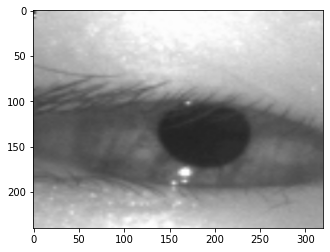

In [11]:
plt.imshow(x),y

## 모델링 수행

In [12]:
kf = KFold(n_splits = 3, shuffle = False)
output_type='float32';output_shape=(240,320,3)
target_label=np.array(['open','closing','closed'])

tp_sum=dict();fn_sum=dict();fp_sum=dict();tn_sum=dict()
for K, (train_idx,test_idx) in enumerate(kf.split(model_files),1):    
    for cutoff in np.arange(0,1.1,0.05):
        for target in target_label:
            cond=f"K_{K}_target_{target}_cutoff_{cutoff:.2f}"
            tp_sum[cond]=0;fn_sum[cond]=0;fp_sum[cond]=0;tn_sum[cond]=0
    test_files=model_files[test_idx]
    test_files =sorted(test_files)
    print("test",len([i for i in test_files if re.compile('open').findall(i)]),\
    len([i for i in test_files if re.compile('closing').findall(i)]),\
    len([i for i in test_files if re.compile('closed').findall(i)]))
    
    print(f"K = {K}, test_length : {len(test_files)}")
    
    random.seed(42)
    te_dataset=tf.data.Dataset.from_generator(
        my_generator(test_files),
        output_shapes=(output_shape, 3),
        output_types=(output_type, output_type))
    te_gen =te_dataset.batch(1).prefetch(1)

    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    model=tf.keras.models.load_model(f'cnn_model_{K}_fold.h5',compile=False)
    ###################
    """
    모델 검증
    """
    for i,(x,y) in tqdm(enumerate(te_gen)):
        for target in range(3):
            y_true=y[:,target].numpy()
            y_pred=model.predict(x)[:,target].astype('float64')            
            for cutoff in np.arange(0,1.1,0.05):
                cond=f"K_{K}_target_{target_label[target]}_cutoff_{cutoff:.02f}"
                tp,fn,fp,tn=my_confusion_matrix(y_true,y_pred,cutoff)
                # tn,fn,fp,tp=confusion_matrix(y_true,y_pred,cutoff=cutoff)
                tp_sum[cond]+=tp;fn_sum[cond]+=fn;fp_sum[cond]+=fp;tn_sum[cond]+=tn

test 600 683 249
K = 1, test_length : 1532


2022-11-24 01:16:06.843924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 01:16:06.848729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 01:16:06.849052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 01:16:06.849963: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

test 575 680 277
K = 2, test_length : 1532


1532it [02:01, 12.58it/s]


test 594 644 293
K = 3, test_length : 1531


1531it [02:01, 12.57it/s]


In [13]:
tpr=dict();fpr=dict()
for K in range(1,4):
    tpr[K]=list();fpr[K]=list()    
    for i in np.arange(0,1.1,.05):
        tp=0;fn=0;fp=0
        for target in target_label:
            tp+=tp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]
            fn+=fn_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]
            fp+=fp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]
            tn+=tn_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]
        tpr[K].append(tp/(tp+fn))
        fpr[K].append(fp/(fp+tn))
        
    tpr[K]=np.array(tpr[K]);fpr[K]=np.array(fpr[K])

In [14]:
joblib.dump([tp_sum,fn_sum,fp_sum,tn_sum],'눈깜빡임지표.pkl')
from itertools import cycle
import matplotlib.pyplot as plt 
import numpy as np
import joblib
from sklearn import metrics
# tp_sum,fn_sum,fp_sum,tn_sum=joblib.load('눈깜빡임지표.pkl')

In [15]:
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
roc_aucs=dict()
for target in target_label:
    tpr=dict();fpr=dict()
    for K in range(1,4):
        tpr[K]=list();fpr[K]=list()    
        for i in np.arange(0,1.1,.05):
            tpr[K].append(tp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]/(
                tp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]+\
                fn_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]))
            fpr[K].append(fp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]/(
                fp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]+\
                tn_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]))
        tpr[K]=np.array(tpr[K]);fpr[K]=np.array(fpr[K])

    for K,color in zip(range(1,4),colors):
        roc_auc=metrics.auc(fpr[K],tpr[K])
        roc_aucs[f"{target}_{K}"]=roc_auc

In [16]:
with open("눈깜빡임지표.json", 'w') as outfile:
    json.dump(roc_aucs, outfile)

In [17]:
np.mean(list(roc_aucs.values()))

0.8529291976171821

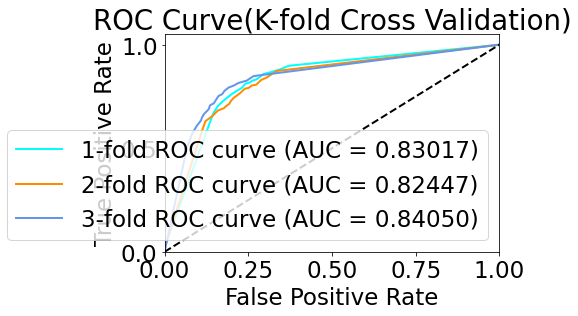

In [18]:
target="open"
tpr=dict();fpr=dict()
for K in range(1,4):
    tpr[K]=list();fpr[K]=list()    
    for i in np.arange(0,1.1,.05):
        tpr[K].append(tp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]/(
            tp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]+fn_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]))
        fpr[K].append(fp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]/(
            fp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]+tn_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]))
    tpr[K]=np.array(tpr[K]);fpr[K]=np.array(fpr[K])
    
plt.figure()
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 23})
plt.figaspect(2)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
lw=2
for K,color in zip(range(1,4),colors):
    roc_auc=metrics.auc(fpr[K],tpr[K])
    plt.plot(
        fpr[K],
        tpr[K],
        label=f"{K}-fold ROC curve (AUC = {roc_auc:0.5f})",
        color=color,
        lw=lw
    )
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve(K-fold Cross Validation)")
plt.legend(loc="lower right")
plt.show()